# Search the Canadian Ice Service ice charts by bounding box or geojson
Items in the API may be searched by a bounding box or GeoJSON. Items intersecting the bounding box or GeoJSON are returned.

For convenience, the badge below launches this notebook on Google [Colab](https://colab.research.google.com/).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/c-core-labs/notebooks/blob/master/notebooks/cis-ice-charts.ipynb)

## Install dependencies
Optionally install dependencies from within the notebook.

In [ ]:
!pip install httpx
!pip install geopandas
!pip install ipyleaflet

## Import dependencies

In [1]:
from typing import List, Dict, Optional
import urllib.parse
import json
import httpx
from ipyleaflet import Map, VectorTileLayer, basemap_to_tiles
import logging


logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

## Base URL for the API
For API documentation, see https://c-stac-api.c-core.app/docs
C-STAC-API implements the STAC API specification. For further details of the API search specification, see https://api.stacspec.org/v1.0.0-rc.1/item-search/

In [2]:
api_url = "https://c-stac-api.c-core.app"

## List all collection IDs in the catalog

In [3]:
def list_collection_ids(url: str = api_url) -> List[str]:
    """List collection IDs in the catalog."""
    get_url = f"{url}/collections"
    
    with httpx.Client(timeout = 20) as client:
        response = client.get(get_url)
    
    try:
        # Raise exception if status code not 2xx success
        response.raise_for_status()
    except httpx.HTTPError as exception:
        log.exception(exception.response.json())
        raise exception
    
    response_body = response.json()
    collections = response_body["collections"]
    collection_ids = [collection["id"] for collection in collections]
    
    return collection_ids
    

In [4]:
collection_ids = list_collection_ids()
collection_ids

['joplin',
 'floe-edge-linestrings',
 'cis-ice-charts',
 'floe-edge-polygons',
 'ice-drift-feature-tracking',
 'floe-edge-convergence',
 'floe-edge-coherence']

## Collection names
The database names differ from the common names assigned to the products for reasons of development history. Here is a map:

- `joplin`: A test collection that is unrelated to the sea ice products.
- `cis-ice-charts`: Canadian Ice Service ice charts.
- `ice-drift-feature-tracking`: Ice tracking.
- `floe-edge-convergence`: Land-fast ice motion.
- `floe-edge-coherence`: Tidal cracks.
- `floe-edge-polygons`: Floe edge as a polygon.
- `floe-edge-linestrings`: Floe edge as a linestring.

## List items in collection
This example uses the GET method, which may be easier for simple listings, compared to the POST method. A POST example appears later.

In [5]:
def list_items( 
    collection_id: str, 
    limit: int = 2,
    sortby: Optional[str] = "-id",
    url: str = api_url
) -> List[Dict]:
    """List items, filtering by geoaptial bbox."""

    # `sortby` need to be urlencoded because it accepts `+`
    url_parameters = f"collections={collection_id}&limit={limit}&sortby={urllib.parse.quote(sortby)}"
    get_collections_url = f"{url}/search?{url_parameters}"
    
    with httpx.Client(timeout = 20) as client:
        log.info(get_collections_url)
        response = client.get(get_collections_url)
    
    try:
        # Raise exception if status code not 2xx success
        response.raise_for_status()
    except httpx.HTTPError as exception:
        log.exception(exception.response.json())
        raise exception
    
    response_body = response.json()
    
    return response_body

Note we can sort by `id`. For descending sort, specify `-id`.

In [6]:
items = list_items("cis-ice-charts", sortby="-id")
[item["properties"]["datetime"] for item in items["features"]]

INFO:__main__:https://c-stac-api.c-core.app/search?collections=cis-ice-charts&limit=2&sortby=-id


['2022-06-13T00:00:00+00:00', '2022-06-12T00:00:00+00:00']

For ascending sort, specify `+id`.

In [32]:
items = list_items("cis-ice-charts", sortby="+id")
[item["properties"]["datetime"] for item in items["features"]]

INFO:__main__:https://c-stac-api.c-core.app/search?collections=cis-ice-charts&limit=2&sortby=%2Bid


['2021-07-14T18:00:00+00:00', '2021-07-15T18:00:00+00:00']

## Filter by location with bbox
This is an example of search by the GET method, which is a convenient way to search by a bounding box (bbox). A search by POST method for more complex queires is demonstarted later.

For further API details, see https://c-stac-api.c-core.app/docs#/default/Search_search_get .
For the API specification, see https://api.stacspec.org/v1.0.0-rc.1/item-search/#operation/getItemSearch .

The GET method accepts a `bbox` parameter. Here, we specify rough bounding boxes for Resolute, Pond Inlet, and the world. The bbox order is `[lower left longitude, lower left latitude, upper right longitude, upper right latitude]`.

In [33]:
bboxes = {
    "resolute": [-97.1, 74.3, -92.5, 75.0],
    "pond_inlet": [-80.6, 72.2, -75.1, 73.2],
    "world": [-180, -90, 180, 90],
}

A convenience function for requesting a search GET method with a bbox.

In [34]:
def list_items_in_bbox(
    bbox: List[float], 
    collection_id: str, 
    limit: int = 2,
    sortby: Optional[str] = "-id",
    url: str = api_url
) -> List[Dict]:
    """List items, filtering by geoaptial bbox."""
    bbox_parameter = ",".join([str(coordinate) for coordinate in bbox])
    
    # `sortby` need to be urlencoded because it accepts `+`
    url_parameters = f"collections={collection_id}&bbox={bbox_parameter}&limit={limit}&sortby={urllib.parse.quote(sortby)}"
    get_collections_url = f"{url}/search?{url_parameters}"
    
    with httpx.Client(timeout = 20) as client:
        log.info(get_collections_url)
        response = client.get(get_collections_url)

    try:
        # Raise exception if status code not 2xx success
        response.raise_for_status()
    except httpx.HTTPError as exception:
        log.exception(exception.response.json())
        raise exception
    
    response_body = response.json()
    
    return response_body

In [35]:
items = list_items_in_bbox(bboxes["pond_inlet"], "cis-ice-charts", sortby="-id")
[item["properties"]["datetime"] for item in items["features"]]

INFO:__main__:https://c-stac-api.c-core.app/search?collections=cis-ice-charts&bbox=-80.6,72.2,-75.1,73.2&limit=2&sortby=-id


['2022-06-13T00:00:00+00:00', '2022-06-12T00:00:00+00:00']

In [36]:
items = list_items_in_bbox(bboxes["pond_inlet"], "cis-ice-charts", sortby="+id")
[item["properties"]["datetime"] for item in items["features"]]

INFO:__main__:https://c-stac-api.c-core.app/search?collections=cis-ice-charts&bbox=-80.6,72.2,-75.1,73.2&limit=2&sortby=%2Bid


['2021-11-01T18:00:00+00:00', '2022-06-12T00:00:00+00:00']

We can also sort by `datetime`. Because `id` includes the value of the datetime, sorting by either probably results in the same results.

In [37]:
items = list_items_in_bbox(bboxes["pond_inlet"], "cis-ice-charts", sortby="-datetime")
[item["properties"]["datetime"] for item in items["features"]]

INFO:__main__:https://c-stac-api.c-core.app/search?collections=cis-ice-charts&bbox=-80.6,72.2,-75.1,73.2&limit=2&sortby=-datetime


['2022-06-13T00:00:00+00:00', '2022-06-12T00:00:00+00:00']

In [38]:
items = list_items_in_bbox(bboxes["pond_inlet"], "cis-ice-charts", sortby="+datetime")
[item["properties"]["datetime"] for item in items["features"]]

INFO:__main__:https://c-stac-api.c-core.app/search?collections=cis-ice-charts&bbox=-80.6,72.2,-75.1,73.2&limit=2&sortby=%2Bdatetime


['2021-11-01T18:00:00+00:00', '2022-06-12T00:00:00+00:00']

## Filter by location with geojson
This is an example of search by the POST method. It requires providing a JSON body with the search request, but allows for more complex queries, such as intersection with a GeoJSON. 

For further API details, see https://c-stac-api.c-core.app/docs#/default/Search_search_post .
For the API specification, see https://api.stacspec.org/v1.0.0-rc.1/item-search/#operation/postItemSearch

Here, we specify GeoJSON polygons surrounding Resolute, Pond Inlet, and the world.

In [39]:
geojsons = {
    "resolute": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -97.09716796875,
              74.27612190544454
            ],
            [
              -92.5103759765625,
              74.27612190544454
            ],
            [
              -92.5103759765625,
              75.00636121985819
            ],
            [
              -97.09716796875,
              75.00636121985819
            ],
            [
              -97.09716796875,
              74.27612190544454
            ]
          ]
        ]
    },
    "pond_inlet": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -80.606689453125,
              72.18852591070342
            ],
            [
              -75.1025390625,
              72.18852591070342
            ],
            [
              -75.1025390625,
              73.18543401519665
            ],
            [
              -80.606689453125,
              73.18543401519665
            ],
            [
              -80.606689453125,
              72.18852591070342
            ]
          ]
        ]
    },
    "world": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -180,
              -90
            ],
            [
              180,
              -90
            ],
            [
              180,
              90
            ],
            [
              -180,
              90
            ],
            [
              -180,
              -90
            ]
          ]
        ]
    }
}

A convenience function for requesting a search POST method with an intersecting GeoJSON.

In [40]:
def list_items_in_geojson(
    geojson: Dict, 
    collection_id: str, 
    limit: int = 2,
    sortby: Optional[List[Dict]] = None,
    url: str = api_url
) -> List[Dict]:
    """List items, filtering by geoaptial bbox."""
    post_url = f"{url}/search"
    
    data = {
        "intersects": geojson,
        "collections": [collection_id],
        "limit": limit,
        "sortby": sortby,
    }
    
    with httpx.Client(timeout = 20) as client:
        log.info(post_url)
        log.info(data)
        response = client.post(post_url, data=json.dumps(data))
    
    try:
        # Raise exception if status code not 2xx success
        response.raise_for_status()
    except httpx.HTTPError as exception:
        log.exception(exception.response.json())
        raise exception
    
    response_body = response.json()
    
    return response_body

When searching with the POST method, `sortby` accespts an array of dictionaries specifying the `field` and `direction`. Here is a datetime descending sort example.

In [41]:
sortby = [{
    "field": "datetime",
    "direction": "desc",
}]

items = list_items_in_geojson(geojsons["pond_inlet"], "cis-ice-charts", sortby=sortby)
[item["properties"]["datetime"] for item in items["features"]]

INFO:__main__:https://c-stac-api.c-core.app/search
INFO:__main__:{'intersects': {'type': 'Polygon', 'coordinates': [[[-80.606689453125, 72.18852591070342], [-75.1025390625, 72.18852591070342], [-75.1025390625, 73.18543401519665], [-80.606689453125, 73.18543401519665], [-80.606689453125, 72.18852591070342]]]}, 'collections': ['cis-ice-charts'], 'limit': 2, 'sortby': [{'field': 'datetime', 'direction': 'desc'}]}


['2022-06-13T00:00:00+00:00', '2022-06-12T00:00:00+00:00']

Here is a datetime ascending sourt example.

In [42]:
sortby = [{
    "field": "datetime",
    "direction": "asc",
}]

items = list_items_in_geojson(geojsons["pond_inlet"], "cis-ice-charts", sortby=sortby)
[item["properties"]["datetime"] for item in items["features"]]

INFO:__main__:https://c-stac-api.c-core.app/search
INFO:__main__:{'intersects': {'type': 'Polygon', 'coordinates': [[[-80.606689453125, 72.18852591070342], [-75.1025390625, 72.18852591070342], [-75.1025390625, 73.18543401519665], [-80.606689453125, 73.18543401519665], [-80.606689453125, 72.18852591070342]]]}, 'collections': ['cis-ice-charts'], 'limit': 2, 'sortby': [{'field': 'datetime', 'direction': 'asc'}]}


['2021-11-01T18:00:00+00:00', '2022-06-12T00:00:00+00:00']

## Example with vector data
Let's plot the most recent floe edge polygon data near Resolute.

In [43]:
sortby = [{
    "field": "datetime",
    "direction": "desc",
}]

items = list_items_in_geojson(geojsons["resolute"], "cis-ice-charts", sortby=sortby, limit=1)
item = items["features"][0]
item

INFO:__main__:https://c-stac-api.c-core.app/search
INFO:__main__:{'intersects': {'type': 'Polygon', 'coordinates': [[[-97.09716796875, 74.27612190544454], [-92.5103759765625, 74.27612190544454], [-92.5103759765625, 75.00636121985819], [-97.09716796875, 75.00636121985819], [-97.09716796875, 74.27612190544454]]]}, 'collections': ['cis-ice-charts'], 'limit': 1, 'sortby': [{'field': 'datetime', 'direction': 'desc'}]}


{'type': 'Feature',
 'geometry': {'coordinates': [[[-43.58839173610251, 58.66489376209507],
    [-43.58839173610251, 80.80427918352213],
    [-103.69417038344184, 80.80427918352213],
    [-103.69417038344184, 58.66489376209507],
    [-43.58839173610251, 58.66489376209507]]],
  'type': 'Polygon'},
 'properties': {'datetime': '2022-06-13T00:00:00+00:00'},
 'id': 'SGRDAEA_20220613',
 'bbox': [-103.69417038344184,
  58.66489376209507,
  -43.58839173610251,
  80.80427918352213],
 'assets': {'geojson': {'title': 'GeoJSON',
   'description': 'GeoJSON',
   'start_datetime': None,
   'end_datetime': None,
   'created': None,
   'updated': None,
   'platform': None,
   'instruments': None,
   'constellation': None,
   'mission': None,
   'providers': None,
   'gsd': None,
   'href': 'https://storage.googleapis.com/cis-ice-charts-public/SGRDAEA_20220613/SGRDAEA_20220613.geojson',
   'type': 'application/geo+json',
   'roles': ['vector-data'],
   'uri': 'gs://cis-ice-charts-public/SGRDAEA_20220613

## Convenience functions
A few convenience functions to extract the vector tile url and vector tile metadata from the STAC item.

In [44]:
def get_vector_tiles_url(item: Dict) -> Optional[str]:
    """Get vector tiles url from STAC item"""
    try:
        url = item["assets"]["vector_tiles"]["href"]
    except KeyError:
        log.warning(f"Item {item['id']} has no vector tile asset")
        return None
    
    return url

In [48]:
def get_vector_tiles_metadata(item: Dict) -> Optional[Dict]:
    """Get vector tiles metadata from STAC item"""
    try:
        if "vector_tiles_metadata" in item["assets"].keys():
            url = item["assets"]["vector_tiles_metadata"]["href"]
        else:
            url = item["assets"]["tileset_metadata"]["href"]
    except KeyError:
        log.warning(f"Item {item['id']} has no vector tile metadata asset")
        return None
    
    with httpx.Client(timeout = 20) as client:
        log.info(url)
        response = client.get(url)
    
    try:
        # Raise exception if status code not 2xx success
        response.raise_for_status()
    except httpx.HTTPError as exception:
        log.exception(exception.response.json())
        raise exception
    
    response_body = response.json()
    
    return response_body

Get the vector tile url and metadata.

In [49]:
url = get_vector_tiles_url(item)
url

'https://storage.googleapis.com/cis-ice-charts-public/SGRDAEA_20220613/{z}/{x}/{y}.pbf'

In [50]:
metadata = get_vector_tiles_metadata(item)
metadata

INFO:__main__:https://storage.googleapis.com/cis-ice-charts-public/SGRDAEA_20220613/SGRDAEA_20220613-tileset-metadata.json


{'name': '/tmp/tmpm7tn0d91',
 'description': '/tmp/tmpm7tn0d91',
 'version': '2',
 'minzoom': '1',
 'maxzoom': '10',
 'center': '-51.855469,64.848834,10',
 'bounds': '-103.694170,58.664894,-43.588392,80.804279',
 'type': 'overlay',
 'format': 'pbf',
 'generator': 'tippecanoe v1.36.0',
 'generator_options': "tippecanoe -l data --output-to-directory /tmp/tmpm7tn0d91 '--minimum-zoom=1' --drop-densest-as-needed --extend-zooms-if-still-dropping --read-parallel -z10 --force /tmp/tmpm7tn0d91/SGRDAEA_20220613.geojson",
 'json': '{"vector_layers": [ { "id": "data", "description": "", "minzoom": 1, "maxzoom": 10, "fields": {"AREA": "Number", "CA": "String", "CB": "String", "CC": "String", "CD": "String", "CF": "String", "CN": "String", "CT": "String", "FA": "String", "FB": "String", "FC": "String", "PERIMETER": "Number", "POLY_TYPE": "String", "SA": "String", "SB": "String", "SC": "String"} } ],"tilestats": {"layerCount": 1,"layers": [{"layer": "data","count": 205,"geometry": "Polygon","attribut

In [51]:
center = [float(coordinate) for coordinate in metadata["center"].split(",")[:2]][::-1]
center

[64.848834, -51.855469]

## Plot vector data

In [52]:
layer = VectorTileLayer(url=url)
map = Map(center=center, zoom=6)
map.add_layer(layer)

map

Map(center=[64.848834, -51.855469], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

In [26]:
def get_raster_tiles_url(item: Dict, tms: Optional[bool] = None) -> Optional[str]:
    """Get raster tiles url from STAC item"""
    try:
        url = item["assets"]["raster_tiles"]["href"]
    except KeyError:
        log.warning(f"Item {item['id']} has no raster tile asset")
        return None
    
    # If url is TMS scheme, need to invert the `y`.
    # https://gist.github.com/tmcw/4954720?permalink_comment_id=3768325#gistcomment-3768325
    if tms:
        url = url.replace("{y}", "{-y}")
    
    return url

## GeoJSON
Get ice chart as a GeoJSON object.

In [54]:
def get_geojson(item: Dict) -> Optional[Dict]:
    """Get ice chart data as geojson."""
    try:
        url = item["assets"]["geojson"]["href"]
    except KeyError:
        log.warning(f"Item {item['id']} has no geojson asset")
        return None
    
    with httpx.Client(timeout = 20) as client:
        log.info(url)
        response = client.get(url)
    
    try:
        # Raise exception if status code not 2xx success
        response.raise_for_status()
    except httpx.HTTPError as exception:
        log.exception(exception.response.json())
        raise exception
    
    response_body = response.json()
    
    return response_body

In [58]:
geojson = get_geojson(item)
geojson["features"][0]

INFO:__main__:https://storage.googleapis.com/cis-ice-charts-public/SGRDAEA_20220613/SGRDAEA_20220613.geojson


{'type': 'Feature',
 'properties': {'AREA': 44620852.6554,
  'PERIMETER': 66516.7286975,
  'CT': '92',
  'CA': '-9',
  'SA': '91',
  'FA': '08',
  'CB': '-9',
  'SB': '-9',
  'FB': '-9',
  'CC': '-9',
  'SC': '-9',
  'FC': '-9',
  'CN': '-9',
  'CD': '-9',
  'CF': '08-9',
  'POLY_TYPE': 'I'},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-64.15422013319042, 59.79000134012374],
    [-64.14755279881867, 59.78664048354326],
    [-64.15088663325452, 59.77497126268959],
    [-64.18172486693128, 59.77372402142633],
    [-64.19505307200184, 59.770363266077275],
    [-64.19914289023578, 59.76416808252639],
    [-64.17749833168766, 59.75997215651503],
    [-64.17758167854032, 59.75249887561682],
    [-64.19088797540576, 59.74247334113419],
    [-64.19088700312501, 59.73913970015188],
    [-64.18338771266045, 59.734553656810384],
    [-64.1666644512681, 59.73122439429473],
    [-64.16007987677175, 59.727055626069244],
    [-64.15499881103487, 59.727028189895705],
    [-64.15422039868888, 

## GeoPandas
GeoPandas can read the ice chart directly from the GeoJSON href.

In [61]:
import geopandas

In [62]:
data_frame = geopandas.read_file(item["assets"]["geojson"]["href"])
data_frame

,AREA,PERIMETER,CT,CA,SA,FA,CB,SB,FB,CC,SC,FC,CN,CD,CF,POLY_TYPE,geometry
0,4.462085e+07,6.651673e+04,92,-9,91,08,-9,-9,-9,-9,-9,-9,-9,-9,08-9,I,"POLYGON ((-64.15422 59.79000, -64.14755 59.786..."
1,2.607002e+06,6.506222e+03,92,-9,91,08,-9,-9,-9,-9,-9,-9,-9,-9,08-9,I,"POLYGON ((-64.05448 59.79746, -64.05688 59.794..."
2,2.101624e+07,2.809654e+04,92,-9,91,08,-9,-9,-9,-9,-9,-9,-9,-9,08-9,I,"POLYGON ((-64.09197 59.86530, -64.09209 59.864..."
3,1.634739e+07,2.032575e+04,92,-9,91,08,-9,-9,-9,-9,-9,-9,-9,-9,08-9,I,"POLYGON ((-64.18973 59.96212, -64.17869 59.953..."
4,5.703091e+07,7.939651e+04,92,-9,91,08,-9,-9,-9,-9,-9,-9,-9,-9,08-9,I,"POLYGON ((-64.21753 60.01336, -64.22250 60.005..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,9.212271e+10,5.740280e+06,None,None,None,None,None,None,None,None,None,None,None,None,None,L,"POLYGON ((-73.13279 79.54962, -73.10728 79.547..."
201,1.360014e+08,5.408321e+04,None,None,None,None,None,None,None,None,None,None,None,None,None,L,"POLYGON ((-95.05664 80.69097, -95.02411 80.680..."
202,4.001161e+10,2.669956e+06,None,None,None,None,None,None,None,None,None,None,None,None,None,L,"POLYGON ((-90.68412 80.60586, -90.66822 80.605..."
203,1.280655e+12,6.595845e+07,None,None,None,None,None,None,None,None,None,None,None,None,None,N,"POLYGON ((-63.50156 79.48926, -63.51160 79.479..."


## Plot with GeoPandas
GeoPandas has it's own default plot method.

<AxesSubplot:>

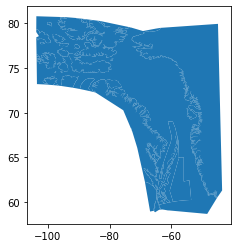

In [64]:
data_frame.plot()

## Download original Shapefile
The original shapefile, as received from the Canadian Ice Services, can also be downloaded.

In [67]:
item["assets"]["shapefile"]["href"]

'https://storage.googleapis.com/cis-ice-charts-public/SGRDAEA_20220613/SGRDAEA_20220613.tar'

In [78]:
import urllib.request
from pathlib import Path

In [82]:
result = urllib.request.urlretrieve(item["assets"]["shapefile"]["href"], f"{item['id']}.tar")
result

('SGRDAEA_20220613.tar', <http.client.HTTPMessage at 0x7fbf8ea51540>)

Confirm shapefile exists on local storage

In [83]:
Path(result[0]).exists()

True